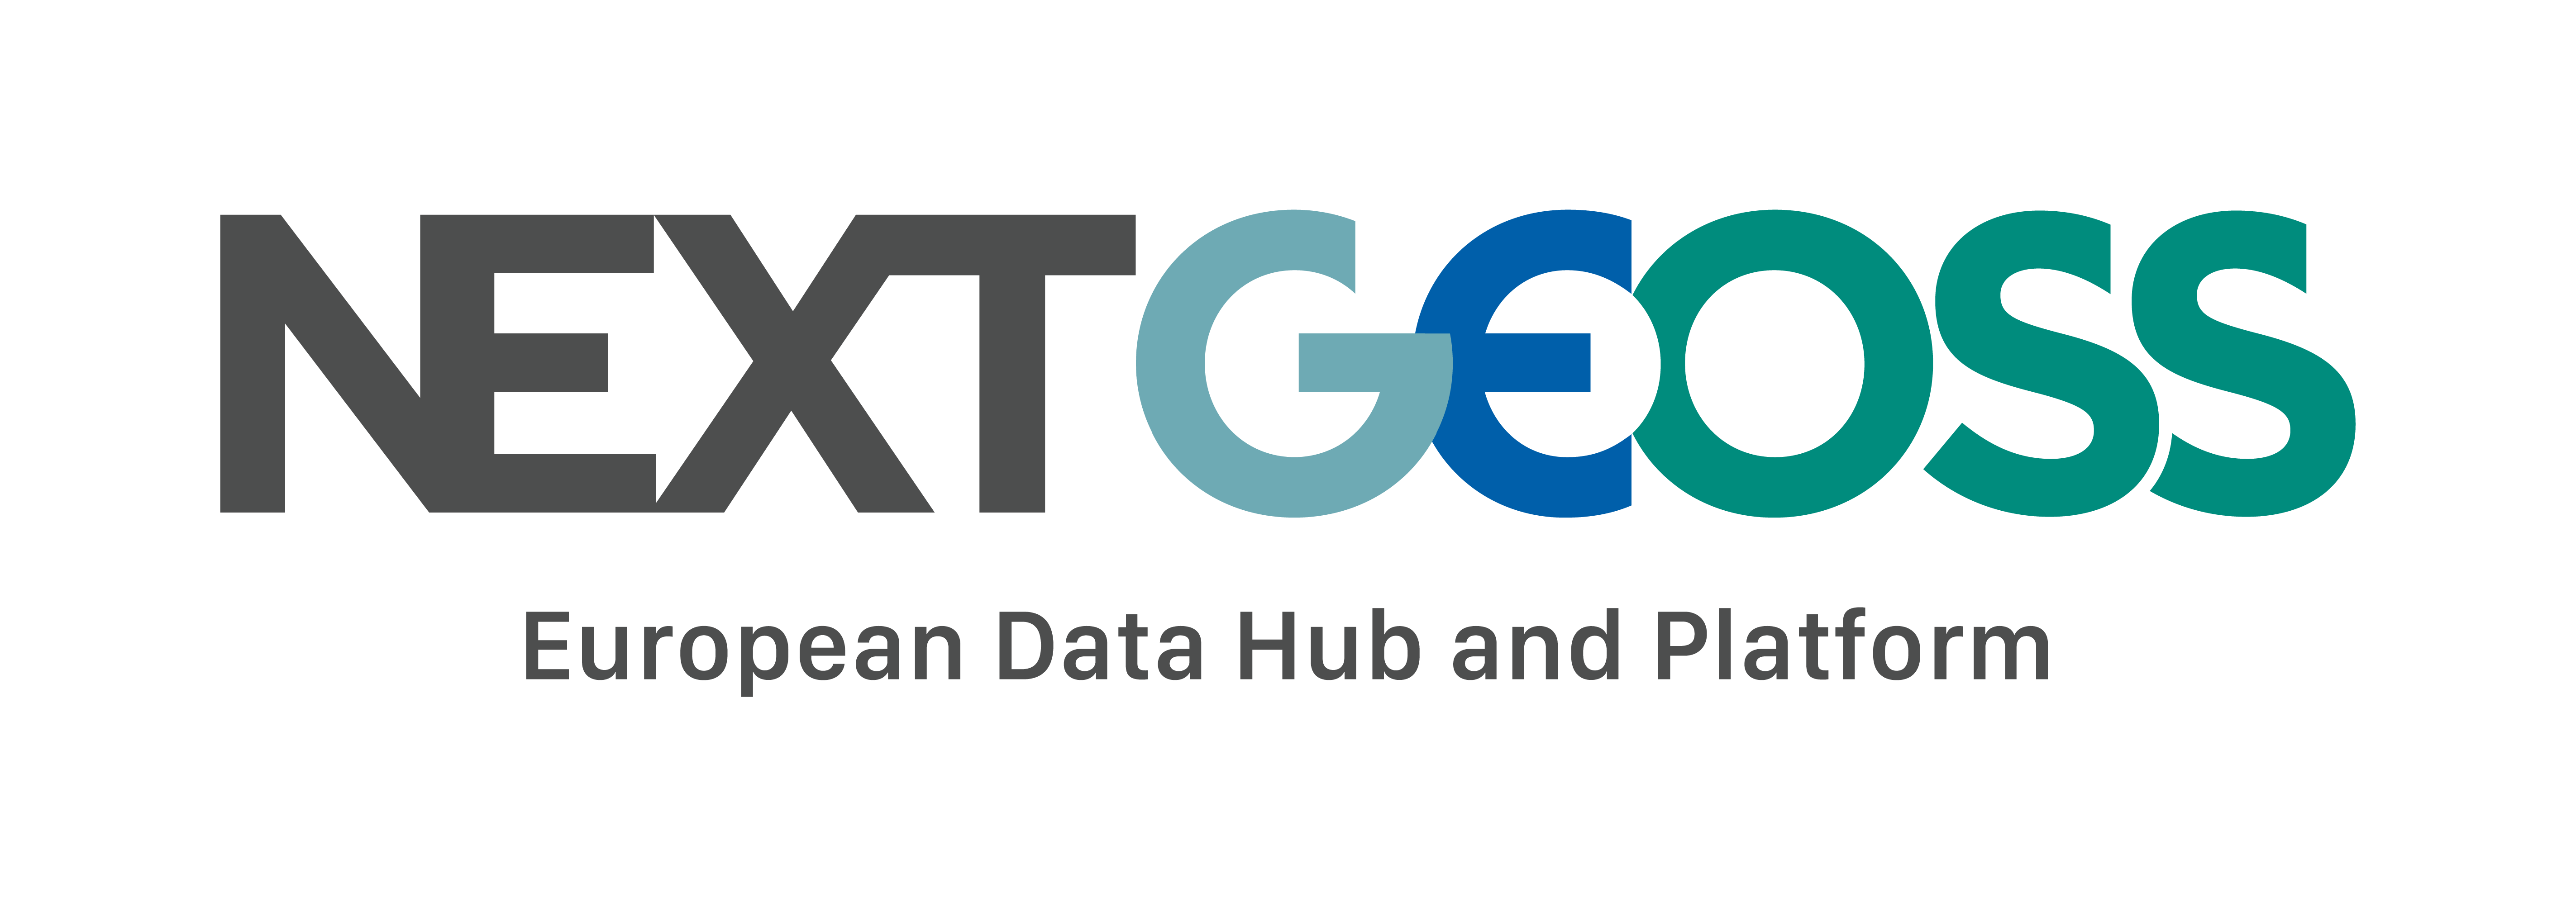

In [1]:
from IPython.display import Image
from IPython.core.display import display, HTML

PATH = "./img/"
Image(filename = PATH + "NextGEOSS-Logo.png", width=512, height=256)

# Introduction to NextGEOSS Energy Pilot (README First !)

## Access time series of gridded data from CAMS Radiation

**This pilot allows to requests for time-series of solar radiation over a regular grid of points covering area of interest (AOI).**

### GEOGRAPHICAL AREA

Geographical coverage of the CAMS radiation product is the field-of-view of the Meteosat satellite, roughly speaking Europe, Africa, Atlantic Ocean, Middle East (-66° to 66° in both latitudes and longitudes).

### DATA

The data you request come from CAMS (Copernicus Atmosphere Monitoring Service) Radiation product from a two years time period including the following parameters (Atmosphere optical properties, Ground reflectance, Cloud optical properties, Atmosphere radiative transfer). **#IMPORTANT NOTE: ONLY THE YEARS 2005 AND 2006 ARE CURRENTLY AVAILABLE FOR THIS PILOT#**

### HOW TO REQUEST THE DATA

The request to the data is made using an **OGC (Open Geospatial Consortium)** standard Web service called **WPS (Web Processing Service)**. This WPS is located remotely on a cloud server and provided as an asynchronous request to the CAMS Radiation process in order to deliver time series of gridded data on a selected AOI (Area Of Interest).

The parameters are first encoded in an url and sent to the Cloud as a WPS request. 

This notebook will first demonstrate how to build the first url. It will then provide a set of command that fully automate the subsequent "treasure hunt" up to the downloading of the data.

### RESULT VISUALISATION

Once downloaded as an HDF5 encode file, the Notebook provides you with results visulaisation:
* An animated display of the time frame layers according to your selection including the global and direct irradiation from both full and clear sky.

**Please allow some time for data to be processed and downloaded. When done you'll have a preview of your time series of gridded data at the bottom of the page. The default example retrieve a full day every 15 mn. from 00:15 providing you with 96 layers over an AOI covering France**


# Setup the Notebook environment (README)

The current version of this Notebook only runs on the Jupyter Hub environment of Terradue and the needed environment to run the application has been already setup.

In order to connect please follow the information as explained in the [« Access instructions »](NextGEOSS-ARMINES-Pilot-1-Access-Instructions.pdf) file.

In [2]:
import re, time, os
from collections import OrderedDict

# some GUI Elements
from ipywidgets import FloatProgress
from IPython.display import display
import ipywidgets as wdg
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, GeoJSON

# Usuall data analysis
import pandas as pd
import h5py
import numpy as np


# To read xml files
import xml.etree.ElementTree as xml

# To download data
from urllib.request import urlopen


class value_handler:
    def __init__(self, key, long_name, value):
        self.key = key
        self.long_name = long_name
        self.value = value

class value_handler_flt(value_handler):
    def __init__(self, *args):
        super().__init__(*args)
    def from_str(self, value):
        self.value = float(value)

class value_handler_int(value_handler):
    def __init__(self, *args):
        super().__init__(*args)
    def from_str(self, value):
        self.value = int(value)

class value_handler_str(value_handler):
    def __init__(self, *args):
        super().__init__(*args)
    def from_str(self, value):
        self.value = str(value)
        
def make_circle(center, radius, rez):
    angles = np.linspace(0.0, 2*np.pi, rez)
    x = np.cos(angles)*radius+center[0]
    y = np.sin(angles)*radius+center[1]
    return np.vstack((y[::-1], x[::-1])).T


In [3]:
namespace = {
    'wps': 'http://www.opengis.net/wps/1.0.0',
    'ows': 'http://www.opengis.net/ows/1.1',
    'mlk': 'http://www.metalinker.org/'
}

# Encoding the request in a url (Optional reading)


The first url is the only wat you need to worry about, as it is where you define the particulars of your request (inputs, methods, outputs etc). 

**Url decomposition**
The url can be decomposed in 4 parts:
* The 'base string' defines the requested service:

In [4]:
# release server
base_str = 'http://solar-mapping.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&'

* The inputs string sets the parameters of the request:

In [5]:
#input_str = 'dataInputs=bbox=-5.0,46.0,6.0,45.0;width=300;height=300;datex=2453385.510416666666;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&'

* The output string:

In [6]:
output_str = 'ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true'

The final url is the aggregation of the 4 parts:

In [7]:
#url_request = base_str+input_str+output_str
#print(url_request)

# Change the input parameters (README)


In this Notebook we've tried to ease the user input parameters selection by including graphical elements known as "widgets". Two  widgets are availables:
* **A free rectangle tool to select an AOI (Area Of Interest)**
* **A set of forms to select additional inputs parameters**
By default those parameters are already filled.

**IMPORTANT**:

When you will see this Notebook for the first time those widgets will not be visible because they rely on external components such as OpenStreetMap background map. Consequetly the Notebook need to be run once before allowing you to view and play with the widget's components.  

As a shortcut you could first directly launch a request with the defaults parameters to enable the display of the graphical widgets.
To do so, go to the JupyterLab top menu and under the "Kernel" dropdown menu select "Restart Kernel and Run All Cells..." item. Confirm the option by clicking on the "RESTART" red button.

Allow for some time for the process to remotly execute and to extract, gather, download and display the results in the Notebook.

Progress bar are availables for both the process execution and when finnished for the download remaining time.

A file named "result.nc" should be available in the "Files" left menu of the JupyterLab and an animation of the gridded time serie should be available at the bottom of the Notebook.

It is also possible to manually modify the url parameters by directly editing the python parameters values below. 
The input parameters can be specified by changing the value in <font color='green'>green</font>. The default example is set for an AOI (Area Of Interest) covering France with a 300x300 resolution for one day (2005 June 22) starting at 00:15h every 15 minutes resulting in HDF file of 96 layers This includes:

* **bot_lat** (Bottom size of a bounding box latitude wise in degree - default is 41.0)
* **top_lat** (Top side of a bounding box latitude wise in degree - default is 51.3)
* **left_lon** (Left side of a bounding box longitude wise in degree - default is -5.5)
* **right_lon** (Right side of a bounding box longiture wise in degree - default is 8.5)
* **width** (Size in pixel of the width of the result map - default is 300)
* **height** (Size in pixel of the height of the result map - default is 300)
* **first_instant** (Begin date in Julian date - default is 2005 Jun 22 at 00:15)
* **dt** (Time span for the number of occurence in Julian time - default is 15 mn)
* **count** (Number of occurence in the time serie of gridded data - default is 96 (Covers 1 day every 15 mn))

In [12]:
# Initialise inputs to default value if not already created
if "inputs" not in globals():
    inputs = OrderedDict([
        ("bot_lat",       value_handler_flt("bot_lat", "Latitude at bottom", 47.17730288735374)),
        ("top_lat",       value_handler_flt("top_lat", "Latitude at top", 47.180146188731785)),
        ("left_lon",      value_handler_flt("left_lon", "Longitude at left", -1.799461856241352)),
        ("right_lon",     value_handler_flt("right_lon", "Longitude at right", -1.796280803677158)),
        ("first_instant", value_handler_str("first_instant", "First instant of the time-series", '2005-06-01')),
        ("last_instant",  value_handler_str("last_instant", "Last instant of the time-series", '2005-06-02')),
        ("summarization", value_handler_str("summarization", "Period of integration in ISO format", "PT15M")),
    ])


In [39]:

map_context = {
    'url': 'http://tiles.osm.webservice-energy.org/osm/{z}/{x}/{y}.png',
    'attribution': '<a href="https://www.openstreetmap.org/copyright">OpenStreeMap</a>',
    'name': 'openstreetmap',
    'max_zoom': 9
}

m = Map(center=((cv(47, 4,58.46)+cv(47,22,23.31))/2, (-1*cv(1,55,23.06)-1*cv(1,19,19.64))/2), zoom=9, layout={'width': '600px', 'height': '300px'})
openstreetmap_layer = basemap_to_tiles(map_context)
m.add_layer(openstreetmap_layer)

def cv(d,m,s):
    return d+m/60+s/60/60

nantes_bbox = [
                              [-1*cv(1,55,23.06), cv(47, 4,58.46)], 
                              [-1*cv(1,56,51.04), cv(47,20,56.30)],
                              [-1*cv(1,20,36.93), cv(47,22,23.31)],
                              [-1*cv(1,19,19.64), cv(47, 6,25.05)],
                              [-1*cv(1,55,23.06), cv(47, 4,58.46)],
]

available_area = GeoJSON(data={
            'type': 'Feature', 
        'properties': {
            'style': {
                'stroke': True, 
                'color': '#00ff00', 
                'weight': 1, 
                'opacity': 0.5,
                'fill': True, 
                'fillColor': None, 
                'fillOpacity': 0.05, 
                'showArea': True, 
                'clickable': False
            }
        }, 
        'geometry': {
            'type': 'Polygon', 
            'coordinates':  [nantes_bbox]
        }
})

m.add_layer(available_area)


def update_current_bbox():
    global current_bbox, m, inputs
    
    try:
        m.remove_layer(current_bbox)
        current_bbox = None
    except:
        pass
    
    current_bbox = GeoJSON(data={
        'type': 'Feature', 
        'properties': {
            'style': {
                'stroke': True, 
                'color': '#ff0000', 
                'weight': 4, 
                'opacity': 0.5, 
                'fill': True, 
                'fillColor': None, 
                'fillOpacity': 0.2, 
                'showArea': True, 
                'clickable': True
            }
        }, 
        'geometry': {
            'type': 'Polygon', 
            'coordinates': [
                [[inputs['left_lon'].value,  inputs['bot_lat'].value], 
                 [inputs['left_lon'].value,  inputs['top_lat'].value], 
                 [inputs['left_lon'].value,  inputs['top_lat'].value], 
                 [inputs['right_lon'].value, inputs['top_lat'].value], 
                 [inputs['right_lon'].value, inputs['bot_lat'].value]]
            ]
        }
    })

    m.add_layer(current_bbox)

update_current_bbox()

wdgs = {}
for xp in inputs.values():
    l = wdg.Label(xp.long_name, layout={'width': '150px'})
    t = (wdg.Text(value=str(xp.value), layout={'width': '150px'}))
    if xp.key in {"left_lon", "right_lon", "bot_lat", "top_lat"}:
        def on_change(x, xp=xp):
            xp.from_str(x['new'])
            update_current_bbox()
    else:
        def on_change(x, xp=xp):
            xp.from_str(x['new'])
            
    t.observe(on_change, names='value')
    wdgs[xp.key] = wdg.HBox([l, t])
    
def xdraw(dc, action, geo_json):
    global m, current_bbox
    dc.clear()    
    # update inputs data
    bbox = np.squeeze(np.array(geo_json['geometry']['coordinates']))
    
    wdgs["left_lon"].children[1].value = str(np.min(bbox[:,0]))
    wdgs["right_lon"].children[1].value = str(np.max(bbox[:,0]))
    wdgs["top_lat"].children[1].value = str(np.max(bbox[:,1]))
    wdgs["bot_lat"].children[1].value = str(np.min(bbox[:,1]))

dc = DrawControl(rectangle={'shapeOptions': {'color': '#ff0000'}}, circlemarker={}, polyline={}, polygon={}, edit=False, remove=False)
dc.on_draw(xdraw)
m.add_control(dc)
print("Select an area using the rectangle tool")

display(m)

layout = [
        [None,          "left_lon"],
        [None,         "right_lon"],
        ["first_instant",  "top_lat"],
        ["last_instant",   "bot_lat"],
        ["summarization",          None]]

display(wdg.VBox([wdg.HBox([wdgs[x] for x in l if x is not None]) for l in layout]))


Select an area using the rectangle tool


Map(center=[47.22802361111111, -1.6225972222222222], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [40]:
# Display inputs in human-readble form,
readable_input = pd.DataFrame([x.value for x in inputs.values()],columns=[''],dtype='object')
readable_input.index = [x.long_name for x in inputs.values()]
display(readable_input)

# Translate input format WPS-appropriate format,
wps_inputs = {x.key: x.value for x in inputs.values()}

input_str = 'dataInputs=bbox={left_lon:f},{top_lat:f},{right_lon:f},{bot_lat:f};date_begin={first_instant:s};date_end={last_instant:s};summarization={summarization:s}&'
input_str = input_str.format(**wps_inputs)

request_size = (wps_inputs["right_lon"]-wps_inputs["left_lon"])*(wps_inputs["top_lat"]-wps_inputs["bot_lat"])
display(HTML("<p>Estimated time: %.1f minutes</p>"%(request_size/14+5,)))
if request_size > 600.0:
    display(HTML("""<span style="color: red;">Request is probably to big</span>"""))


,
Latitude at bottom,47.1769
Latitude at top,47.1862
Longitude at left,-1.62213
Longitude at right,-1.6084
First instant of the time-series,2005-06-01
Last instant of the time-series,2005-06-02
Period of integration in ISO format,PT15M


In [18]:
url_request = base_str+input_str+output_str
print(url_request)

http://solar-mapping.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&dataInputs=bbox=-1.799462,47.180146,-1.796281,47.177303;date_begin=2005-06-01;date_end=2005-06-02;summarization=PT15M&ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true


# Submit the request to the WPS server (Optional reading)

In [19]:
# Warning: this line launches a request. It should not be called several time
# r = PoolManager().request('GET', url_request)
r = urlopen(url_request)
tree = xml.fromstring(r.read().decode("utf-8"))
if not tree.tag == "{http://www.opengis.net/wps/1.0.0}ExecuteResponse":
    raise Exception("Unexpected response")
if tree.find("./{http://www.opengis.net/wps/1.0.0}Status/{http://www.opengis.net/wps/1.0.0}ProcessAccepted") is None:
    raise Exception("Process was not accepted, please check your parameters")
status_url = tree.attrib["statusLocation"]
print("Process accepted with folowing status url:")
print(status_url)
print("you do not need to run it again.")

Process accepted with folowing status url:
http://solar-mapping.armines.nextgeoss.terradue.com/wps/RetrieveResultServlet?id=379b1a6b-0298-4499-9ab0-69bb4ddb45cd
you do not need to run it again.


# Wait for the WPS response (Display progress bar)

In [20]:
## The server response may be failed or Succeded
print("please wait for the server")

p = wdg.FloatProgress(min=0, max=100, description='Waiting:')
l = wdg.Label()
display(wdg.HBox([p, l]))

while True:
    r = urlopen(status_url)
    tree = xml.fromstring(r.read().decode("utf-8"))
    if not tree.tag == "{http://www.opengis.net/wps/1.0.0}ExecuteResponse":
        Exception("Unexpected response")
    status = tree.find("./{http://www.opengis.net/wps/1.0.0}Status/*")
    if status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessFailed":
        error = status.find(".//{http://www.opengis.net/ows/1.1}ExceptionText")
        raise Exception("WPS Process fail with error: %s"%(error.text))
    elif status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessStarted":
        p.value = int(status.attrib["percentCompleted"])
        l.value = "%d%%"%(p.value,)
    elif status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessAccepted":
        pass
    elif status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessPaused":
        print("Process paused")
    elif status.tag == "{http://www.opengis.net/wps/1.0.0}ProcessSucceeded":
        p.value = 100
        l.value = "100%"
        break
    time.sleep(10)
print("Process succeeded")
# TODO: Get the result link

please wait for the server


Exception: WPS Process fail with error: java.lang.RuntimeException: Error executing 

# Retreive the result from the WPS server (Optional reading)

In [ ]:
outputs = tree.findall("./wps:ProcessOutputs/wps:Output", namespace)
if outputs is None:
    raise Exception("No outputs found!")

output_metalink = None
for o in outputs:
    identifier = o.find("./ows:Identifier", namespace)
    if identifier is None:
        continue
    if identifier.text == "result_distribution":
        ref = o.find("./wps:Data/wps:ComplexData/wps:Reference", namespace)
        if ref is None:
            raise Exception("No Reference link found!")
        output_metalink = ref.attrib['href']
        
if output_metalink is None:
    raise Exception("Output reference link not found!")

r = urlopen(output_metalink)
t = xml.fromstring(r.read().decode("utf-8"))
if t.tag != '{http://www.metalinker.org/}metalink':
    raise Exception("Invalid metalink")

link = t.find("./mlk:files/mlk:file[@name='result.nc']/mlk:resources/mlk:url", namespace)
if link is None:
    raise Exception("No result file url found!")
final_url = link.text

link = t.find("./mlk:files/mlk:file[@name='meta.json']/mlk:resources/mlk:url", namespace)
if link is None:
    raise Exception("No meta file url found!")
meta_url = link.text

print("Result URL: ", final_url)
print("Meta URL: ", meta_url)

# Download final data (Display progress bar)

In [ ]:
r = urlopen(final_url)

if 'content-length' in r.headers:
    content_length = int(r.headers['content-length'])

    print('Downloading %.1fMo:'%(content_length/1e6))
    p = wdg.FloatProgress(min=0, max=content_length, description='Downloading:')
    l = wdg.Label()
    display(wdg.HBox([p, l]))

    with open("result.nc", "wb") as f:
        while True:
            buffer = r.read(4096*64)
            if len(buffer) == 0:
                break
            p.value += len(buffer)
            l.value = "%.1f%%"%((p.value*100/content_length),)
            f.write(buffer)

    print("Download finished!")
else:
    print('Downloading...')
    with open("result.nc", "wb") as f:
        while True:
            buffer = r.read(4096*64)
            if len(buffer) == 0:
                break
            f.write(buffer)
    print("Download finished!")

# Animation of the time serie of gridded data (README)

### Code and libraries needed to display the data (Optional reading)

In [ ]:
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import h5py
import sys

# Guess the FFMEG executatble path
plt.rc('animation', ffmpeg_path=sys.executable.replace('python', 'ffmpeg'))
plt.rc('animation', embed_limit=2**31)

# Some possible more options
#plt.rc('animation', ffmpeg_path='/workspace/.conda/envs/armines-pilot/bin/ffmpeg')
#plt.rc('animation', writer='ffmpeg_file')
#plt.rc('animation', codec='vp9')

%matplotlib inline

from itertools import product

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.io import DownloadWarning
import warnings

# ignore cartopy warning
warnings.simplefilter("ignore",  category=DownloadWarning)


In [ ]:
# Define cartopy features:
resolution = "50m"
BORDERS = NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                              resolution, edgecolor='black', facecolor='none')
STATES = NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes',
                             resolution, edgecolor='black', facecolor='none')
COASTLINE = NaturalEarthFeature('physical', 'coastline', resolution,
                                edgecolor='black', facecolor='none')
LAKES = NaturalEarthFeature('physical', 'lakes', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'])
LAND = NaturalEarthFeature('physical', 'land', resolution,
                           edgecolor='face',
                           facecolor=COLORS['land'], zorder=-1)
OCEAN = NaturalEarthFeature('physical', 'ocean', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'], zorder=-1)
RIVERS = NaturalEarthFeature('physical', 'rivers_lake_centerlines', resolution,
                             edgecolor=COLORS['water'],
                             facecolor='none')

### Animation of the variability in space and in time of the solar resource within the selected period (REAME)

**Click on the > play button below to run the animation.**

In [ ]:
# Load downloaded data in notebook:

from tempfile import NamedTemporaryFile

# Create animation:
extent = [inputs["left_lon"].value, inputs["right_lon"].value, inputs["bot_lat"].value, inputs["top_lat"].value]

fig, ax = plt.subplots(2, 2, figsize=(11, 7), subplot_kw={'projection': ccrs.PlateCarree()})
im = np.zeros((2,2), dtype='object')
cb = np.zeros((2,2), dtype='object')
ne = np.array([['GHI', 'BHI'], ['GHI_CLS', 'BHI_CLS']])

with h5py.File('result.nc', 'r') as hf:

    for a, b in product(range(2), range(2)):
        name = ne[a,b]
        data = hf[name][:,:,:]
        xmax = np.max(data[np.isfinite(data)])
        im[a,b] = ax[a,b].imshow(hf[name][0,:,:], animated=True, vmin=0, vmax=xmax, origin='lower', transform=ccrs.PlateCarree(), extent=extent)
        ax[a,b].set_title("%s, frame: %d"%(name, 0))
        ax[a,b].add_feature(BORDERS)
        ax[a,b].add_feature(COASTLINE)
        cb[a,b] = fig.colorbar(im[a,b], ax=ax[a,b], shrink=0.7)
        cb[a,b].set_label(r'$W/m^{2}$', size='large')

    def updatefig(frame, *args):
        global im, hf, ax
        for a, b in product(range(2), range(2)):
            name = ne[a,b]
            ax[a,b].set_title("%s, frame: %d"%(name, frame))
            im[a,b].set_data(hf[name][frame, :, :])
        return im[0,0], im[0,1], im[1,0], im[1,1]

    ani = animation.FuncAnimation(fig, updatefig, frames=range(inputs["count"].value), interval=200, blit=True)

    fvideo = NamedTemporaryFile(prefix="video_", suffix=".webm", dir='/workspace', delete=True)
    ani.save(fvideo.name, writer=animation.FFMpegWriter(codec='vp9', bitrate=2000000))
    plt.close(fig) # Avoid figure to be drawn twice

# Show the video
HTML("""
<video controls autoplay>
  <source src="{fvideo}" type="video/mp4">
</video>
""".format(fvideo="/"+os.path.basename(fvideo.name)))

# Do not work with this version of matplotlib
#HTML(ani.to_jshtml())


# Exploit the information to support decision making (README)

In this Notebook example we want to provide you with the possibily to go further than the process and download possibilties. This is why we have developped a second Notebook that will illustrate **how to use and exploit the information retreived in order to support decision making**. This Notebook will illustrates the following:

* A use case where a time-series of a single is point is compared to an average of gridded data over a given region (NUTS-3 shape)
* A use case where a time-series of a single is point is compared to an average of gridded data over a given geometrical AOI (Area Of Interest)
* A use case where we compute the daily average irrdiation per department for France

Please load the following link to proceed: [here](NextGEOSSFranceAggregation.ipynb)